<a href="https://colab.research.google.com/github/KShuvalova/NIR/blob/main/1%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install polars pyarrow tqdm torch

import os, re, io, json, random
from pathlib import Path
from zipfile import ZipFile
from tqdm.auto import tqdm

import numpy as np
import polars as pl
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount("/content/drive")

KT1_ZIP = Path("/content/drive/MyDrive/Colab Projects/EdNet-Analysis/data/EdNet-KT1.zip")
DATA_DIR = KT1_ZIP.parent
DATA_DIR.mkdir(parents=True, exist_ok=True)

assert KT1_ZIP.exists(), f"ZIP not found: {KT1_ZIP}"
print("KT1_ZIP:", KT1_ZIP)
print("Size (GB):", KT1_ZIP.stat().st_size / 1e9)

Mounted at /content/drive
KT1_ZIP: /content/drive/MyDrive/Colab Projects/EdNet-Analysis/data/EdNet-KT1.zip
Size (GB): 1.201163816


In [3]:
USER_FILE_PATTERN = re.compile(r".*/u\d+\.csv$")
def reservoir_sample_zip_members(zip_path: Path, pattern=USER_FILE_PATTERN, k=2000, seed=42):
    rng = random.Random(seed)
    chosen = []
    n_seen = 0

    with ZipFile(zip_path, "r") as zf:
        for info in zf.infolist():
            name = info.filename
            if not pattern.match(name):
                continue
            n_seen += 1
            if len(chosen) < k:
                chosen.append(name)
            else:
                j = rng.randrange(n_seen)
                if j < k:
                    chosen[j] = name
    return chosen, n_seen

def detect_header(raw_bytes: bytes) -> bool:
    if not raw_bytes:
        return False
    first_line = raw_bytes[:300].decode("utf-8", errors="ignore").splitlines()[0].lower()
    return ("timestamp" in first_line) and ("question" in first_line)

COLS = ["timestamp", "solving_id", "question_id", "user_answer", "elapsed_time"]

def read_one_user_csv_from_zip(zf: ZipFile, member_name: str) -> pl.DataFrame:
    m = re.search(r"u(\d+)\.csv$", member_name)
    uid = int(m.group(1)) if m else -1

    raw = zf.read(member_name)
    has_header = detect_header(raw)

    buf = io.BytesIO(raw)
    if has_header:
        df = pl.read_csv(buf)
        if set(COLS).issubset(set(df.columns)):
            df = df.select(COLS)
        else:
            df = df.select(df.columns[:5]).rename(dict(zip(df.columns[:5], COLS)))
    else:
        df = pl.read_csv(buf, has_header=False, new_columns=COLS)

    return df.with_columns(pl.lit(uid).alias("user_id"))

In [4]:
SAMPLE_USERS = 2000
members, total_user_files = reservoir_sample_zip_members(KT1_ZIP, k=SAMPLE_USERS, seed=42)

print("Total user CSVs found in ZIP:", total_user_files)
print("Sampled users:", len(members))
print("Example members:", members[:5])

dfs = []
with ZipFile(KT1_ZIP, "r") as zf:
    for name in tqdm(members, desc="Reading user CSVs from ZIP"):
        try:
            dfs.append(read_one_user_csv_from_zip(zf, name))
        except Exception:
            continue

df_raw = pl.concat(dfs, how="vertical", rechunk=True)
print("Sample rows/cols:", df_raw.shape)
df_raw.head()

Total user CSVs found in ZIP: 784309
Sampled users: 2000
Example members: ['KT1/u316193.csv', 'KT1/u378178.csv', 'KT1/u165231.csv', 'KT1/u82226.csv', 'KT1/u719094.csv']


Reading user CSVs from ZIP:   0%|          | 0/2000 [00:00<?, ?it/s]

Sample rows/cols: (215956, 6)


timestamp,solving_id,question_id,user_answer,elapsed_time,user_id
i64,i64,str,str,i64,i32
1541361920475,1,"""q5759""","""c""",18000,316193
1541361934300,2,"""q5881""","""c""",10000,316193
1541361976702,3,"""q3622""","""c""",39000,316193
1541362005241,4,"""q5805""","""a""",26000,316193
1541362036573,5,"""q5365""","""c""",29000,316193


In [5]:
df = (
    df_raw
    .with_columns([
        pl.col("user_id").cast(pl.Int32),
        pl.col("timestamp").cast(pl.Int64, strict=False),
        pl.col("solving_id").cast(pl.Int64, strict=False),
        pl.col("question_id").cast(pl.Utf8),
        pl.col("user_answer").cast(pl.Utf8).fill_null("not_choose"),
        pl.col("elapsed_time").cast(pl.Int64, strict=False),
    ])
    .drop_nulls(subset=["timestamp", "question_id"])
)
df = df.sort(["user_id", "timestamp"])

print("Users:", df.select(pl.n_unique("user_id")).item())
print("Questions:", df.select(pl.n_unique("question_id")).item())
print("Rows:", df.height)
df.head()

Users: 2000
Questions: 11798
Rows: 215956


timestamp,solving_id,question_id,user_answer,elapsed_time,user_id
i64,i64,str,str,i64,i32
1561522500603,1,"""q6355""","""a""",8000,476
1561522515901,2,"""q3692""","""c""",11000,476
1561522543830,3,"""q3817""","""b""",25000,476
1561522573293,4,"""q5248""","""a""",27000,476
1561522590858,5,"""q3914""","""a""",15000,476


In [6]:
import json
SESSION_GAP_SEC = 30 * 60

df_feat = (
    df
    .sort(["user_id", "timestamp"])
    .with_columns([
        (pl.col("elapsed_time") / 1000.0).alias("elapsed_sec"),
        ((pl.col("timestamp").diff().over("user_id")) / 1000.0).fill_null(0).alias("delta_sec"),
    ])
)

df_feat = df_feat.with_columns(
    (pl.col("delta_sec") > SESSION_GAP_SEC).cast(pl.Int8).alias("new_session_flag")
)
df_feat = df_feat.with_columns(
    pl.col("new_session_flag").cum_sum().over("user_id").alias("session_id")
)

elapsed_bins = [5, 15, 30, 60, 120, 300]
delta_bins   = [10, 60, 5*60, 30*60, 24*3600]

df_feat = df_feat.with_columns([
    pl.col("elapsed_sec").cut(elapsed_bins).alias("elapsed_bucket"),
    pl.col("delta_sec").cut(delta_bins).alias("delta_bucket"),
])

ans_map = {"a": 0, "b": 1, "c": 2, "d": 3, "not_choose": 4}
df_feat = df_feat.with_columns(
    pl.col("user_answer")
      .cast(pl.Utf8)
      .fill_null("not_choose")
      .map_elements(lambda x: ans_map.get(x, 4), return_dtype=pl.Int64)  # <- Int64 always OK
      .cast(pl.Int8)
      .alias("ans")
)



elapsed_map = (
    df_feat
    .select("elapsed_bucket")
    .unique()
    .drop_nulls()
    .sort("elapsed_bucket")
    .with_row_index("elapsed_b")  # 0..n-1
    .with_columns(pl.col("elapsed_b").cast(pl.Int16))
)

delta_map = (
    df_feat
    .select("delta_bucket")
    .unique()
    .drop_nulls()
    .sort("delta_bucket")
    .with_row_index("delta_b")
    .with_columns(pl.col("delta_b").cast(pl.Int16))
)

df_feat = (
    df_feat
    .join(elapsed_map, on="elapsed_bucket", how="left")
    .join(delta_map, on="delta_bucket", how="left")
    .with_columns([
        pl.col("elapsed_b").fill_null(-1).cast(pl.Int16),
        pl.col("delta_b").fill_null(-1).cast(pl.Int16),
    ])
)

def qid_to_int(q) -> int:
    if q is None:
        return -1
    q = str(q)
    if len(q) > 1 and q[0].lower() == "q" and q[1:].isdigit():
        return int(q[1:])
    return (hash(q) % (2**31 - 1))

df_feat = df_feat.with_columns([
    pl.col("question_id").map_elements(qid_to_int, return_dtype=pl.Int64).cast(pl.Int32).alias("qid"),
    pl.col("user_id").cast(pl.Int32).alias("uid"),
])

VAL_K = 20
TEST_K = 20

df_feat = (
    df_feat
    .sort(["uid", "timestamp"])
    .with_columns([
        pl.int_range(0, pl.len()).over("uid").alias("t_idx"),
        pl.len().over("uid").alias("seq_len"),
    ])
    .with_columns([
        pl.when(pl.col("t_idx") >= pl.col("seq_len") - TEST_K).then(pl.lit("test"))
         .when(pl.col("t_idx") >= pl.col("seq_len") - (TEST_K + VAL_K)).then(pl.lit("val"))
         .otherwise(pl.lit("train"))
         .alias("split")
    ])
)

model_df = df_feat.select([
    "uid", "session_id", "timestamp",
    "qid", "ans",
    "elapsed_b", "delta_b",
    "split"
])

print(model_df.shape)
model_df.head()

import json

OUT_PARQUET = DATA_DIR / "kt1_sample_preprocessed.parquet"
VOCAB_JSON  = DATA_DIR / "kt1_vocabs.json"
ELAPSED_MAP_CSV = DATA_DIR / "elapsed_bucket_map.csv"
DELTA_MAP_CSV   = DATA_DIR / "delta_bucket_map.csv"

model_df.write_parquet(OUT_PARQUET)
elapsed_map.write_csv(ELAPSED_MAP_CSV)
delta_map.write_csv(DELTA_MAP_CSV)

with open(VOCAB_JSON, "w", encoding="utf-8") as f:
    json.dump(
        {
            "answer_map": ans_map,
            "elapsed_bins": elapsed_bins,
            "delta_bins": delta_bins,
            "session_gap_sec": SESSION_GAP_SEC,
            "elapsed_bucket_map_file": str(ELAPSED_MAP_CSV),
            "delta_bucket_map_file": str(DELTA_MAP_CSV),
        },
        f, ensure_ascii=False, indent=2
    )

OUT_PARQUET = DATA_DIR / "kt1_sample_preprocessed.parquet"
VOCAB_JSON  = DATA_DIR / "kt1_vocabs.json"
ELAPSED_MAP_CSV = DATA_DIR / "elapsed_bucket_map.csv"
DELTA_MAP_CSV   = DATA_DIR / "delta_bucket_map.csv"

model_df.write_parquet(OUT_PARQUET)
elapsed_map.write_csv(ELAPSED_MAP_CSV)
delta_map.write_csv(DELTA_MAP_CSV)

with open(VOCAB_JSON, "w", encoding="utf-8") as f:
    json.dump(
        {
            "answer_map": ans_map,
            "elapsed_bins": elapsed_bins,
            "delta_bins": delta_bins,
            "session_gap_sec": SESSION_GAP_SEC,
            "elapsed_bucket_map_file": str(ELAPSED_MAP_CSV),
            "delta_bucket_map_file": str(DELTA_MAP_CSV),
        },
        f, ensure_ascii=False, indent=2
    )

(215956, 8)


In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

class KTNextStepDataset(Dataset):
    """
    Predic on sequences:
      x = [qid, ans, elapsed_b, delta_b]
      y = next qid (same length as x)
    """
    def __init__(self, df: pl.DataFrame, seq_len: int = 200, split: str = "train"):
        self.seq_len = seq_len
        d = df.filter(pl.col("split") == split).sort(["uid", "timestamp"])

        self.users = d.select("uid").unique().to_series().to_list()

        self.user_rows = {}
        self.windows = []

        for uid, sub in d.group_by("uid", maintain_order=True):
            uid = int(uid[0])
            sub = sub.sort("timestamp")
            arr_q = sub["qid"].to_numpy()
            if len(arr_q) < seq_len + 1:
                continue

            self.user_rows[uid] = {
                "qid": arr_q,
                "ans": sub["ans"].to_numpy(),
                "elapsed_b": sub["elapsed_b"].to_numpy(),
                "delta_b": sub["delta_b"].to_numpy(),
            }
            step = seq_len
            for start in range(0, len(arr_q) - (seq_len + 1), step):
                self.windows.append((uid, start))

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        uid, start = self.windows[idx]
        rows = self.user_rows[uid]
        sl = slice(start, start + self.seq_len)

        x_qid = torch.tensor(rows["qid"][sl], dtype=torch.long)
        x_ans = torch.tensor(rows["ans"][sl], dtype=torch.long)
        x_et  = torch.tensor(rows["elapsed_b"][sl], dtype=torch.long)
        x_dt  = torch.tensor(rows["delta_b"][sl], dtype=torch.long)


        y = torch.tensor(rows["qid"][start + 1 : start + self.seq_len + 1], dtype=torch.long)

        x = torch.stack([x_qid, x_ans, x_et, x_dt], dim=-1)  # [T, 4]
        return x, y

df_parq = pl.read_parquet(OUT_PARQUET)

train_ds = KTNextStepDataset(df_parq, seq_len=200, split="train")
val_ds   = KTNextStepDataset(df_parq, seq_len=200, split="val")

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)

print("Train windows:", len(train_ds), "Val windows:", len(val_ds))
x, y = next(iter(train_loader))
print("x:", x.shape, "y:", y.shape)

Train windows: 736 Val windows: 0
x: torch.Size([32, 200, 4]) y: torch.Size([32, 200])


In [8]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

model_df = model_df.with_columns([
    pl.col("uid").cast(pl.Int32),
    pl.col("session_id").cast(pl.Int32),
    pl.col("timestamp").cast(pl.Int64),
    pl.col("qid").cast(pl.Int32),
    pl.col("ans").cast(pl.Int8),
    pl.col("elapsed_b").cast(pl.Int16),
    pl.col("delta_b").cast(pl.Int16),
    pl.col("split").cast(pl.Utf8),
])

#Tempo profile
p80 = model_df.select(pl.col("elapsed_b").quantile(0.8)).item()
print("Global elapsed_b P80:", p80)

user_behavior = (
    model_df
    .filter(pl.col("split") == "train")
    .group_by("uid")
    .agg([
        pl.len().alias("n_events"),
        pl.n_unique("session_id").alias("n_sessions"),
        pl.col("elapsed_b").mean().alias("tempo_mean_bucket"),
        (pl.col("elapsed_b") >= p80).mean().alias("slow_share"),
        pl.col("delta_b").mean().alias("pause_mean_bucket"),
    ])
    .sort("n_events", descending=True)
)

user_behavior.head(10)

Global elapsed_b P80: 3.0


uid,n_events,n_sessions,tempo_mean_bucket,slow_share,pause_mean_bucket
i32,u32,u32,f64,f64,f64
148689,6635,243,2.262246,0.279578,0.813112
20557,6064,95,1.722131,0.166722,0.850594
245423,5395,312,2.452085,0.445042,1.331789
123407,4421,150,2.174621,0.291789,1.0095
185885,3961,165,2.066145,0.23277,1.203484
11416,3932,291,2.03179,0.211597,1.545015
136817,3662,106,2.042327,0.186783,0.945385
758818,3653,149,2.179031,0.315357,1.011224
80940,3159,136,1.605255,0.02754,0.946186


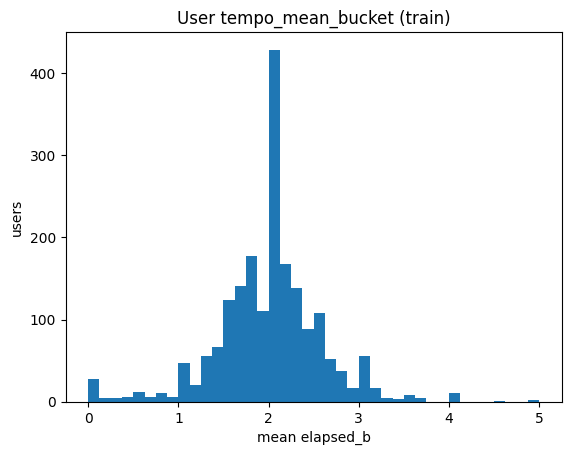

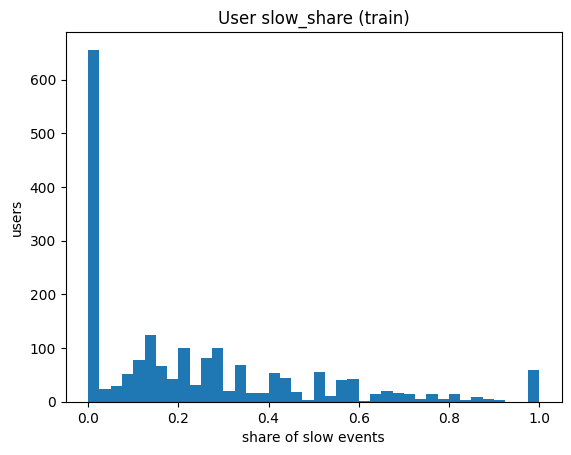

In [9]:
tempo = user_behavior["tempo_mean_bucket"].to_numpy()
slow  = user_behavior["slow_share"].to_numpy()

plt.figure()
plt.hist(tempo[np.isfinite(tempo)], bins=40)
plt.title("User tempo_mean_bucket (train)")
plt.xlabel("mean elapsed_b"); plt.ylabel("users")
plt.show()

plt.figure()
plt.hist(slow[np.isfinite(slow)], bins=40)
plt.title("User slow_share (train)")
plt.xlabel("share of slow events"); plt.ylabel("users")
plt.show()

In [10]:
max_delta_b = model_df.select(pl.col("delta_b").max()).item()
print("max delta_b:", max_delta_b)

user_dropout_proxy = (
    model_df
    .filter(pl.col("split") == "train")
    .with_columns((pl.col("delta_b") == max_delta_b).cast(pl.Int8).alias("long_gap"))
    .group_by("uid")
    .agg([
        pl.len().alias("n_events"),
        pl.col("long_gap").mean().alias("long_gap_rate"),
    ])
    .sort("long_gap_rate", descending=True)
)

user_dropout_proxy.head(10)

max delta_b: 5


uid,n_events,long_gap_rate
i32,u32,f64
790548,2,0.5
795022,2,0.5
798989,2,0.5
815921,2,0.5
114148,4,0.25
116375,4,0.25
126339,4,0.25
229606,8,0.25
498822,4,0.25


In [11]:
user_stability = (
    model_df
    .filter(pl.col("split") == "train")
    .group_by("uid")
    .agg([
        pl.col("elapsed_b").std().alias("tempo_std"),
        pl.col("delta_b").std().alias("pause_std"),
    ])
    .sort("tempo_std", descending=True)
)

user_stability.head(10)

uid,tempo_std,pause_std
i32,f64,f64
22593,null,null
41909,null,null
43302,null,null
50335,null,null
68840,null,null
74343,null,null
78325,null,null
79888,null,null
86258,null,null


In [12]:
!pip -q install torch

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

train_qids = model_df.filter(pl.col("split") == "train").select("qid").unique()
qid_list = train_qids["qid"].to_list()
qid_to_idx = {qid:i+1 for i, qid in enumerate(qid_list)}
UNK = 0

def map_qid_to_idx(qid: int) -> int:
    return qid_to_idx.get(int(qid), UNK)

ANS_VOCAB = 5
ELAPSED_VOCAB = int(model_df.select(pl.col("elapsed_b").max()).item()) + 2
DELTA_VOCAB   = int(model_df.select(pl.col("delta_b").max()).item()) + 2

print("Q vocab:", len(qid_to_idx)+1, "ANS:", ANS_VOCAB, "EL:", ELAPSED_VOCAB, "DL:", DELTA_VOCAB)

Q vocab: 11746 ANS: 5 EL: 8 DL: 7


In [13]:
class KTWindowDataset(Dataset):
    def __init__(self, df: pl.DataFrame, split: str, seq_len: int = 200, step: int = 200):
        self.seq_len = seq_len
        self.step = step

        d = df.filter(pl.col("split") == split).sort(["uid", "timestamp"])
        self.windows = []
        self.user_data = {}

        for uid, sub in d.group_by("uid", maintain_order=True):
            uid = int(uid[0])
            sub = sub.sort("timestamp")

            q = sub["qid"].to_list()
            a = sub["ans"].to_list()
            e = sub["elapsed_b"].to_list()
            g = sub["delta_b"].to_list()

            q = [map_qid_to_idx(x) for x in q]

            if len(q) < seq_len + 1:
                continue

            self.user_data[uid] = (q, a, e, g)

            for start in range(0, len(q) - (seq_len + 1), step):
                self.windows.append((uid, start))

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        uid, start = self.windows[idx]
        q, a, e, g = self.user_data[uid]

        sl = slice(start, start + self.seq_len)
        qx = torch.tensor(q[sl], dtype=torch.long)
        ax = torch.tensor(a[sl], dtype=torch.long)
        ex = torch.tensor(e[sl], dtype=torch.long)
        gx = torch.tensor(g[sl], dtype=torch.long)

        y = torch.tensor(q[start+1 : start + self.seq_len + 1], dtype=torch.long)

        return (qx, ax, ex, gx), y, uid

SEQ_LEN = 200
train_ds = KTWindowDataset(model_df, "train", seq_len=SEQ_LEN, step=SEQ_LEN)
val_ds   = KTWindowDataset(model_df, "val",   seq_len=SEQ_LEN, step=SEQ_LEN)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=0)

print("train windows:", len(train_ds), "val windows:", len(val_ds))

train windows: 736 val windows: 0


In [14]:
class GRUKT(nn.Module):
    def __init__(self, q_vocab: int, ans_vocab: int, el_vocab: int, dl_vocab: int,
                 d_model: int = 128, hidden: int = 128):
        super().__init__()
        self.q_emb  = nn.Embedding(q_vocab, d_model, padding_idx=0)
        self.a_emb  = nn.Embedding(ans_vocab, d_model)
        self.el_emb = nn.Embedding(el_vocab, d_model)
        self.dl_emb = nn.Embedding(dl_vocab, d_model)

        self.gru = nn.GRU(input_size=d_model*4, hidden_size=hidden, batch_first=True)
        self.out = nn.Linear(hidden, q_vocab)

    def forward(self, qx, ax, ex, gx):
        x = torch.cat([
            self.q_emb(qx),
            self.a_emb(ax),
            self.el_emb(ex),
            self.dl_emb(gx),
        ], dim=-1)

        h_seq, h_last = self.gru(x)
        logits = self.out(h_seq)
        return logits, h_seq, h_last

device = "cuda" if torch.cuda.is_available() else "cpu"
model = GRUKT(
    q_vocab=len(qid_to_idx)+1,
    ans_vocab=ANS_VOCAB,
    el_vocab=ELAPSED_VOCAB,
    dl_vocab=DELTA_VOCAB,
    d_model=64,
    hidden=128
).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=2e-3)
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [15]:
def run_epoch(loader, train=True):
    model.train(train)
    total_loss, n = 0.0, 0
    for (qx, ax, ex, gx), y, _ in loader:
        qx, ax, ex, gx, y = qx.to(device), ax.to(device), ex.to(device), gx.to(device), y.to(device)
        logits, _, _ = model(qx, ax, ex, gx)

        loss = criterion(logits.reshape(-1, logits.size(-1)), y.reshape(-1))

        if train:
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        total_loss += float(loss.item()) * qx.size(0)
        n += qx.size(0)

    return total_loss / max(n, 1)

EPOCHS = 2
for ep in range(1, EPOCHS+1):
    tr = run_epoch(train_loader, train=True)
    va = run_epoch(val_loader, train=False)
    print(f"Epoch {ep}: train_loss={tr:.4f} val_loss={va:.4f}")

Epoch 1: train_loss=9.1796 val_loss=0.0000
Epoch 2: train_loss=8.6442 val_loss=0.0000


In [16]:
from collections import defaultdict

model.eval()
user_sum = defaultdict(lambda: torch.zeros(128))
user_cnt = defaultdict(int)

with torch.no_grad():
    for (qx, ax, ex, gx), _, uids in tqdm(train_loader, desc="Extract embeddings"):
        qx, ax, ex, gx = qx.to(device), ax.to(device), ex.to(device), gx.to(device)
        _, _, h_last = model(qx, ax, ex, gx)
        emb = h_last.squeeze(0).cpu()

        for i, uid in enumerate(uids):
            uid = int(uid)
            user_sum[uid] += emb[i]
            user_cnt[uid] += 1

user_emb = {uid: (user_sum[uid] / user_cnt[uid]).numpy() for uid in user_sum.keys()}
print("Extracted user embeddings:", len(user_emb), "dim:", next(iter(user_emb.values())).shape)

Extract embeddings:   0%|          | 0/12 [00:00<?, ?it/s]

Extracted user embeddings: 155 dim: (128,)


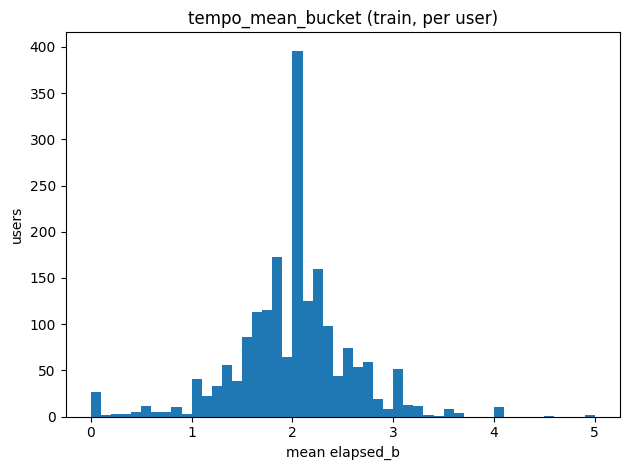

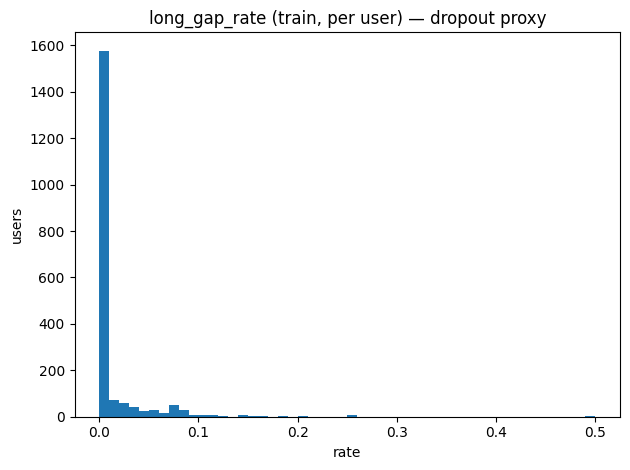

Train windows: 736 Val windows: 0
Epoch 1: train_loss=9.1730 val_loss=nan
Epoch 2: train_loss=8.6231 val_loss=nan
Saved: /content/drive/MyDrive/Colab Projects/EdNet-Analysis/results_run/train_history.csv


Extract embeddings:   0%|          | 0/12 [00:00<?, ?it/s]

Best K: 2 silhouette: 0.4778787


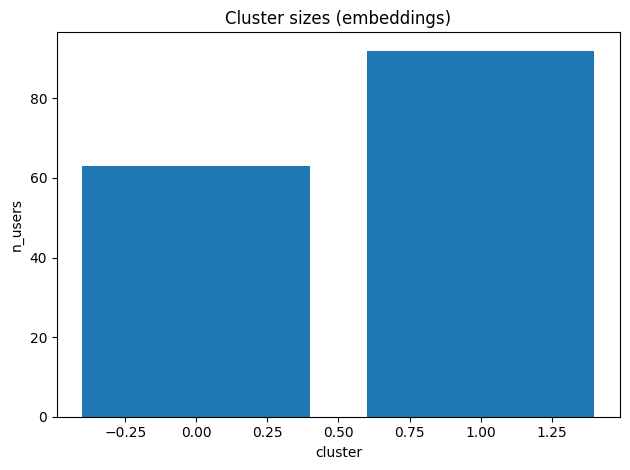

In [17]:
!pip -q install polars pyarrow tqdm torch scikit-learn

import os, json, math, random
from pathlib import Path
from collections import defaultdict
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

OUT_DIR = Path("/content/drive/MyDrive/Colab Projects/EdNet-Analysis/results_run")
OUT_DIR.mkdir(parents=True, exist_ok=True)

required_cols = ["uid","session_id","timestamp","qid","ans","elapsed_b","delta_b","split"]
missing = [c for c in required_cols if c not in model_df.columns]
assert not missing, f"model_df is missing columns: {missing}"

model_df = model_df.with_columns([
    pl.col("uid").cast(pl.Int32),
    pl.col("session_id").cast(pl.Int32),
    pl.col("timestamp").cast(pl.Int64),
    pl.col("qid").cast(pl.Int32),
    pl.col("ans").cast(pl.Int16),
    pl.col("elapsed_b").cast(pl.Int16),
    pl.col("delta_b").cast(pl.Int16),
    pl.col("split").cast(pl.Utf8),
]).sort(["uid","timestamp"])

MODEL_PARQUET = OUT_DIR / "model_df.parquet"
model_df.write_parquet(MODEL_PARQUET)

train_df = model_df.filter(pl.col("split") == "train")

p80_elapsed = train_df.select(pl.col("elapsed_b").quantile(0.8)).item()
max_delta_b = train_df.select(pl.col("delta_b").max()).item()

user_metrics = (
    train_df
    .with_columns((pl.col("delta_b") == max_delta_b).cast(pl.Int8).alias("long_gap"))
    .group_by("uid")
    .agg([
        pl.len().alias("n_events"),
        pl.n_unique("session_id").alias("n_sessions"),
        pl.col("elapsed_b").mean().alias("tempo_mean_bucket"),
        pl.col("elapsed_b").std().fill_null(0).alias("tempo_std_bucket"),
        (pl.col("elapsed_b") >= p80_elapsed).mean().alias("slow_share"),
        pl.col("delta_b").mean().alias("pause_mean_bucket"),
        pl.col("delta_b").std().fill_null(0).alias("pause_std_bucket"),
        pl.col("long_gap").mean().alias("long_gap_rate"),
    ])
    .sort("n_events", descending=True)
)

USER_METRICS_CSV = OUT_DIR / "user_metrics.csv"
user_metrics.write_csv(USER_METRICS_CSV)

plt.figure()
plt.hist(user_metrics["tempo_mean_bucket"].to_numpy(), bins=50)
plt.title("tempo_mean_bucket (train, per user)")
plt.xlabel("mean elapsed_b"); plt.ylabel("users")
plt.tight_layout()
plt.savefig(OUT_DIR / "hist_tempo_mean_bucket.png", dpi=150)
plt.show()

plt.figure()
plt.hist(user_metrics["long_gap_rate"].to_numpy(), bins=50)
plt.title("long_gap_rate (train, per user) — dropout proxy")
plt.xlabel("rate"); plt.ylabel("users")
plt.tight_layout()
plt.savefig(OUT_DIR / "hist_long_gap_rate.png", dpi=150)
plt.show()

train_qids = train_df.select("qid").unique()["qid"].to_list()
qid_to_idx = {int(q): i+1 for i, q in enumerate(train_qids)}  # 0 = UNK/PAD
idx_to_qid = {v: k for k, v in qid_to_idx.items()}
Q_VOCAB = len(qid_to_idx) + 1

ANS_VOCAB = int(model_df.select(pl.col("ans").max()).item()) + 2
EL_VOCAB  = int(model_df.select(pl.col("elapsed_b").max()).item()) + 2
DL_VOCAB  = int(model_df.select(pl.col("delta_b").max()).item()) + 2

VOCAB_JSON = OUT_DIR / "vocab.json"
with open(VOCAB_JSON, "w", encoding="utf-8") as f:
    json.dump(
        {
            "Q_VOCAB": Q_VOCAB,
            "ANS_VOCAB": ANS_VOCAB,
            "EL_VOCAB": EL_VOCAB,
            "DL_VOCAB": DL_VOCAB,
            "qid_to_idx_size": len(qid_to_idx),
            "note": "qid_to_idx built from TRAIN qids only; 0 is UNK/PAD",
        },
        f, ensure_ascii=False, indent=2
    )

def map_qid_to_idx(qid: int) -> int:
    return qid_to_idx.get(int(qid), 0)

class KTWindowDataset(Dataset):
    def __init__(self, df: pl.DataFrame, split: str, seq_len: int = 200, step: int = 200):
        self.seq_len = seq_len
        self.step = step

        d = df.filter(pl.col("split") == split).sort(["uid", "timestamp"])
        self.windows = []
        self.user_data = {}

        for uid, sub in d.group_by("uid", maintain_order=True):
            uid = int(uid[0])
            sub = sub.sort("timestamp")

            q = [map_qid_to_idx(x) for x in sub["qid"].to_list()]
            a = sub["ans"].to_list()
            e = sub["elapsed_b"].to_list()
            g = sub["delta_b"].to_list()

            if len(q) < seq_len + 1:
                continue

            self.user_data[uid] = (q, a, e, g)

            for start in range(0, len(q) - (seq_len + 1), step):
                self.windows.append((uid, start))

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        uid, start = self.windows[idx]
        q, a, e, g = self.user_data[uid]
        sl = slice(start, start + self.seq_len)

        qx = torch.tensor(q[sl], dtype=torch.long)
        ax = torch.tensor(a[sl], dtype=torch.long)
        ex = torch.tensor(e[sl], dtype=torch.long)
        gx = torch.tensor(g[sl], dtype=torch.long)

        y = torch.tensor(q[start+1 : start + self.seq_len + 1], dtype=torch.long)

        return (qx, ax, ex, gx), y, uid

SEQ_LEN = 200
BATCH = 64

train_ds = KTWindowDataset(model_df, "train", seq_len=SEQ_LEN, step=SEQ_LEN)
val_ds   = KTWindowDataset(model_df, "val",   seq_len=SEQ_LEN, step=SEQ_LEN)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=0)

print("Train windows:", len(train_ds), "Val windows:", len(val_ds))

# GRU Model
class GRUKT(nn.Module):
    def __init__(self, q_vocab, ans_vocab, el_vocab, dl_vocab, d_model=64, hidden=128):
        super().__init__()
        self.q_emb  = nn.Embedding(q_vocab, d_model, padding_idx=0)
        self.a_emb  = nn.Embedding(ans_vocab, d_model)
        self.el_emb = nn.Embedding(el_vocab, d_model)
        self.dl_emb = nn.Embedding(dl_vocab, d_model)

        self.gru = nn.GRU(input_size=d_model*4, hidden_size=hidden, batch_first=True)
        self.out = nn.Linear(hidden, q_vocab)

    def forward(self, qx, ax, ex, gx):
        x = torch.cat([self.q_emb(qx), self.a_emb(ax), self.el_emb(ex), self.dl_emb(gx)], dim=-1)
        h_seq, h_last = self.gru(x)
        logits = self.out(h_seq)
        return logits, h_seq, h_last

device = "cuda" if torch.cuda.is_available() else "cpu"
model = GRUKT(Q_VOCAB, ANS_VOCAB, EL_VOCAB, DL_VOCAB, d_model=64, hidden=128).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=2e-3)
criterion = nn.CrossEntropyLoss(ignore_index=0)

def run_epoch(loader, train=True):
    model.train(train)
    total_loss, n = 0.0, 0
    for (qx, ax, ex, gx), y, _ in loader:
        qx, ax, ex, gx, y = qx.to(device), ax.to(device), ex.to(device), gx.to(device), y.to(device)
        logits, _, _ = model(qx, ax, ex, gx)
        loss = criterion(logits.reshape(-1, logits.size(-1)), y.reshape(-1))

        if train:
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        total_loss += float(loss.item()) * qx.size(0)
        n += qx.size(0)
    return total_loss / max(n, 1)

EPOCHS = 2
history = []
for ep in range(1, EPOCHS+1):
    tr = run_epoch(train_loader, train=True)
    va = run_epoch(val_loader, train=False) if len(val_ds) > 0 else float("nan")
    history.append({"epoch": ep, "train_loss": tr, "val_loss": va})
    print(f"Epoch {ep}: train_loss={tr:.4f} val_loss={va:.4f}")

HIST_CSV = OUT_DIR / "train_history.csv"
pl.DataFrame(history).write_csv(HIST_CSV)
print("Saved:", HIST_CSV)

MODEL_PT = OUT_DIR / "gru_model.pt"
torch.save(model.state_dict(), MODEL_PT)

# extract embeddings
model.eval()
user_sum = defaultdict(lambda: torch.zeros(128))
user_cnt = defaultdict(int)

with torch.no_grad():
    for (qx, ax, ex, gx), _, uids in tqdm(train_loader, desc="Extract embeddings"):
        qx, ax, ex, gx = qx.to(device), ax.to(device), ex.to(device), gx.to(device)
        _, _, h_last = model(qx, ax, ex, gx)
        emb = h_last.squeeze(0).cpu()
        for i, uid in enumerate(uids):
            uid = int(uid)
            user_sum[uid] += emb[i]
            user_cnt[uid] += 1

user_ids = sorted(user_sum.keys())
emb_mat = np.stack([(user_sum[uid] / user_cnt[uid]).numpy() for uid in user_ids], axis=0)  # [N,H]

EMB_NPY = OUT_DIR / "user_embeddings.npy"
np.save(EMB_NPY, emb_mat)

USER_IDS_NPY = OUT_DIR / "user_ids.npy"
np.save(USER_IDS_NPY, np.array(user_ids, dtype=np.int32))
emb_preview = pl.DataFrame(
    {"uid": user_ids, **{f"emb_{i}": emb_mat[:, i] for i in range(min(10, emb_mat.shape[1]))}}
)
EMB_PREVIEW_CSV = OUT_DIR / "user_embeddings_preview.csv"
emb_preview.write_csv(EMB_PREVIEW_CSV)

# cluster embeddings + cluster profiling by behavior metrics
metrics_pd = user_metrics.select(["uid","n_events","n_sessions","tempo_mean_bucket","tempo_std_bucket","slow_share",
                                 "pause_mean_bucket","pause_std_bucket","long_gap_rate"])

Ks = [2,3,4,5,6,7,8]
sil_scores = []
best_k, best_sil = None, -1

if emb_mat.shape[0] >= 50:
    for k in Ks:
        km = KMeans(n_clusters=k, n_init="auto", random_state=42)
        labels = km.fit_predict(emb_mat)
        sil = silhouette_score(emb_mat, labels)
        sil_scores.append({"k": k, "silhouette": float(sil)})
        if sil > best_sil:
            best_sil, best_k = sil, k
else:
    best_k = 3
    sil_scores.append({"k": best_k, "silhouette": float("nan")})

print("Best K:", best_k, "silhouette:", best_sil)

SIL_CSV = OUT_DIR / "silhouette_scores.csv"
pl.DataFrame(sil_scores).write_csv(SIL_CSV)

kmeans = KMeans(n_clusters=best_k, n_init="auto", random_state=42)
labels = kmeans.fit_predict(emb_mat)

CLUSTERS_CSV = OUT_DIR / "user_clusters.csv"
pl.DataFrame({"uid": user_ids, "cluster": labels}).write_csv(CLUSTERS_CSV)

clusters_df = pl.DataFrame({"uid": user_ids, "cluster": labels}).join(metrics_pd, on="uid", how="left")

cluster_profile = (
    clusters_df
    .group_by("cluster")
    .agg([
        pl.len().alias("n_users"),
        pl.col("n_events").median().alias("median_events"),
        pl.col("tempo_mean_bucket").mean().alias("tempo_mean"),
        pl.col("tempo_std_bucket").mean().alias("tempo_std"),
        pl.col("slow_share").mean().alias("slow_share_mean"),
        pl.col("pause_mean_bucket").mean().alias("pause_mean"),
        pl.col("pause_std_bucket").mean().alias("pause_std"),
        pl.col("long_gap_rate").mean().alias("long_gap_rate_mean"),
    ])
    .sort("n_users", descending=True)
)

CLUSTER_PROFILE_CSV = OUT_DIR / "cluster_profile.csv"
cluster_profile.write_csv(CLUSTER_PROFILE_CSV)

# plot cluster sizes
plt.figure()
plt.bar(cluster_profile["cluster"].to_list(), cluster_profile["n_users"].to_list())
plt.title("Cluster sizes (embeddings)")
plt.xlabel("cluster"); plt.ylabel("n_users")
plt.tight_layout()
plt.savefig(OUT_DIR / "cluster_sizes.png", dpi=150)
plt.show()

controls = (
    user_metrics
    .with_columns([
        pl.when((pl.col("tempo_mean_bucket") <= pl.col("tempo_mean_bucket").quantile(0.4)) &
                (pl.col("slow_share") <= pl.col("slow_share").quantile(0.4)))
          .then(pl.lit("fast"))
          .otherwise(pl.lit("calm"))
          .alias("target_pacing"),

        pl.when((pl.col("slow_share") >= pl.col("slow_share").quantile(0.7)) |
                (pl.col("tempo_std_bucket") >= pl.col("tempo_std_bucket").quantile(0.7)))
          .then(pl.lit(2))
          .otherwise(pl.lit(1))
          .alias("hint_level"),

        pl.when(pl.col("long_gap_rate") >= pl.col("long_gap_rate").quantile(0.7))
          .then(pl.lit(-1))
          .otherwise(pl.lit(0))
          .alias("difficulty_shift"),
    ])
    .select(["uid","target_pacing","hint_level","difficulty_shift"])
)

CONTROLS_CSV = OUT_DIR / "generation_controls_proxy.csv"
controls.write_csv(CONTROLS_CSV)


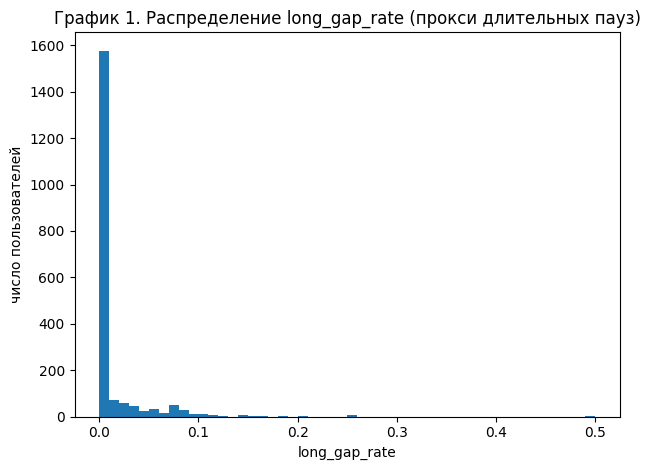

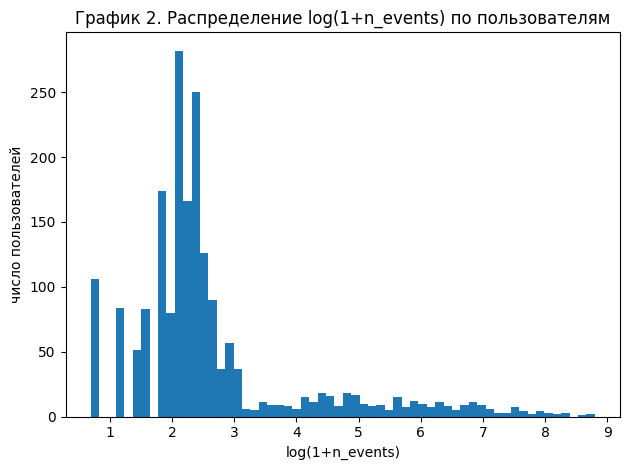

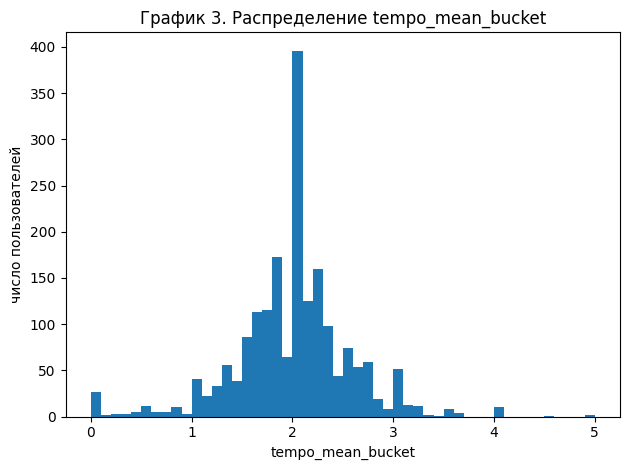

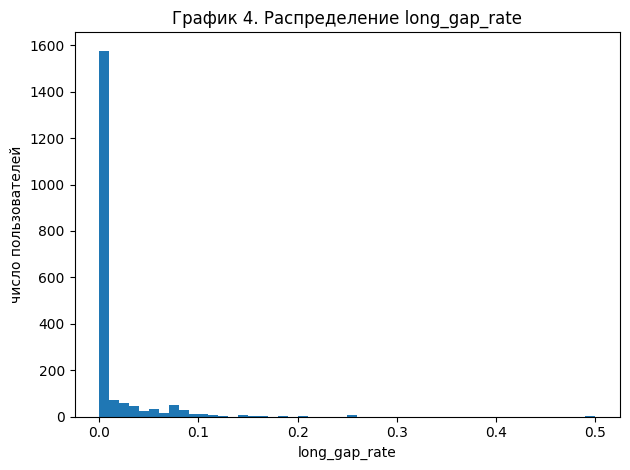

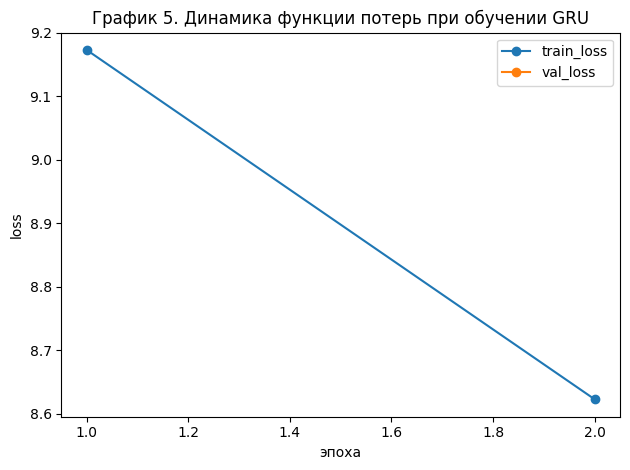

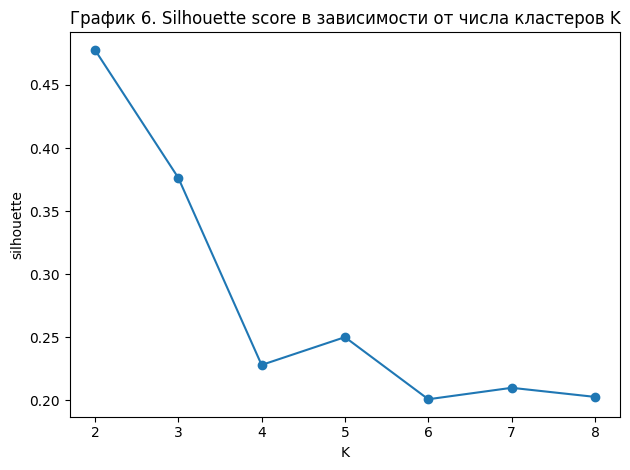

,cluster,n_users,median_events,tempo_mean,tempo_std,slow_share_mean,pause_mean,pause_std,long_gap_rate_mean
0,1,92,476.5,1.934868,0.754376,0.192399,1.370184,0.981554,0.023951
1,0,63,939.0,2.205888,0.852043,0.326323,1.173951,1.124860,0.014277


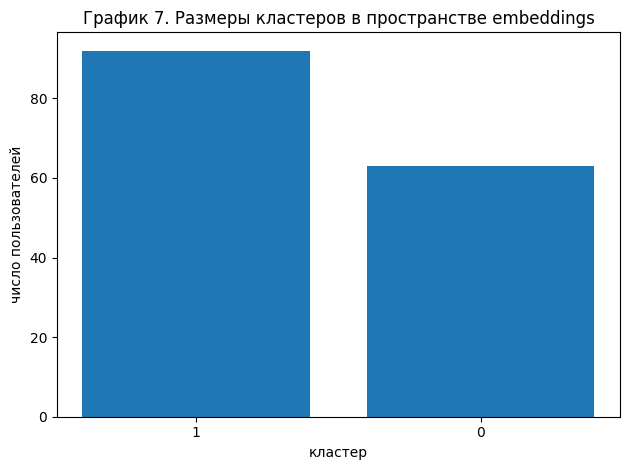

/tmp/ipython-input-3656971502.py:99: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([d0, d1], labels=["cluster 0", "cluster 1"], showfliers=False)


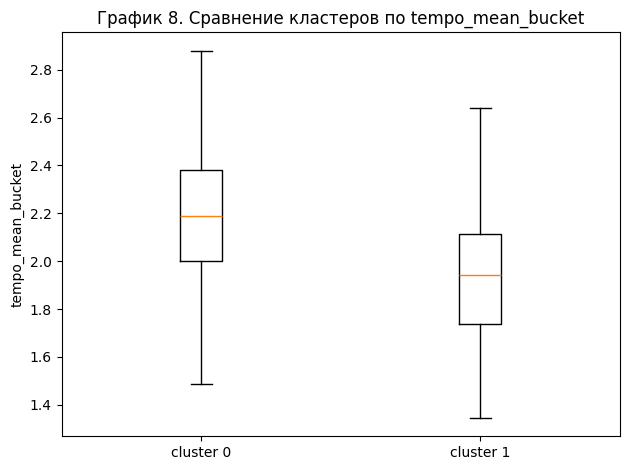

/tmp/ipython-input-3656971502.py:99: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([d0, d1], labels=["cluster 0", "cluster 1"], showfliers=False)


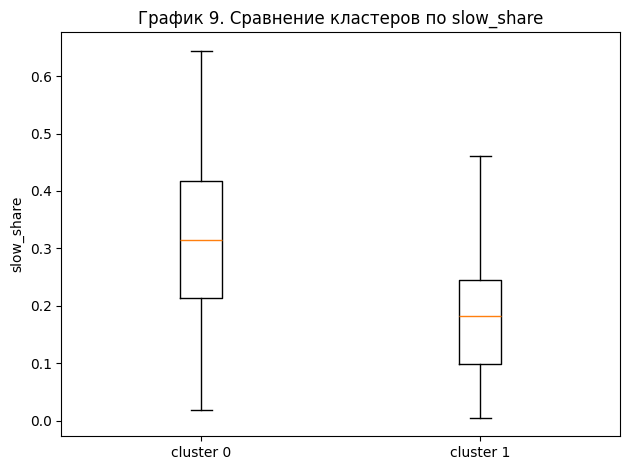

/tmp/ipython-input-3656971502.py:99: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([d0, d1], labels=["cluster 0", "cluster 1"], showfliers=False)


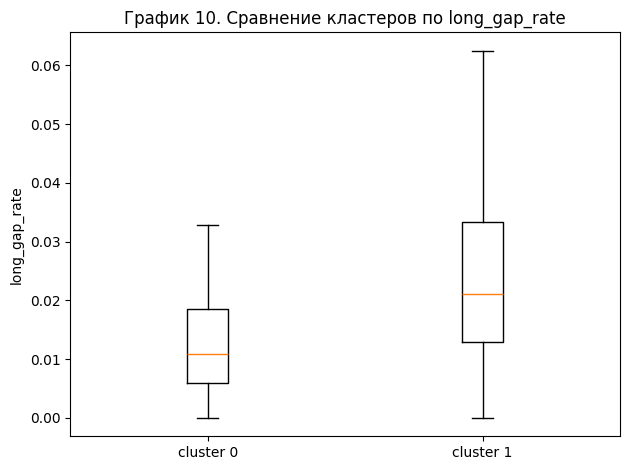

Таблица 3а. Распределение target_pacing:
 target_pacing
calm    1402
fast     554
Name: count, dtype: int64

Таблица 3б. Распределение hint_level:
 hint_level
1    1032
2     924
Name: count, dtype: int64


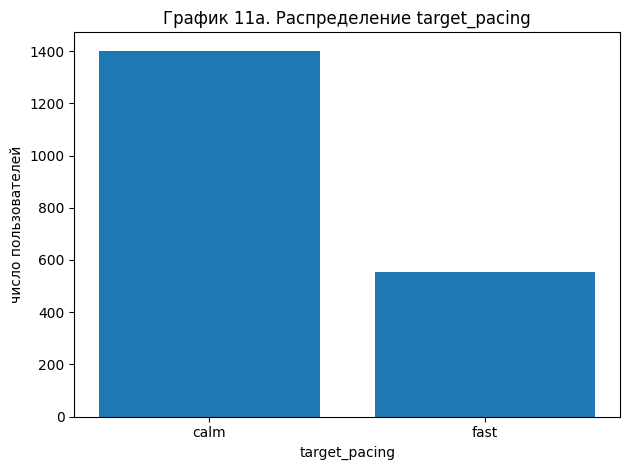

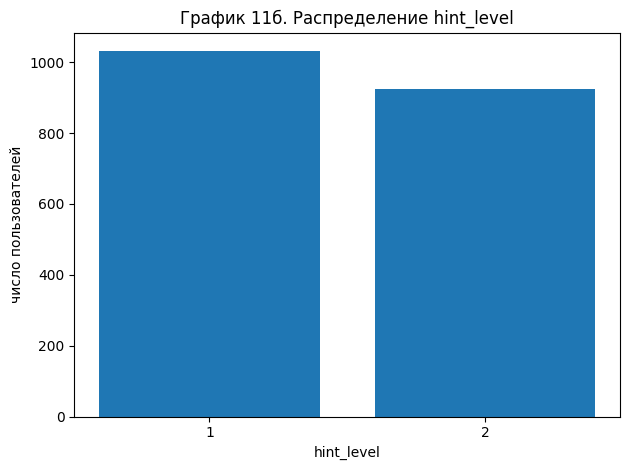

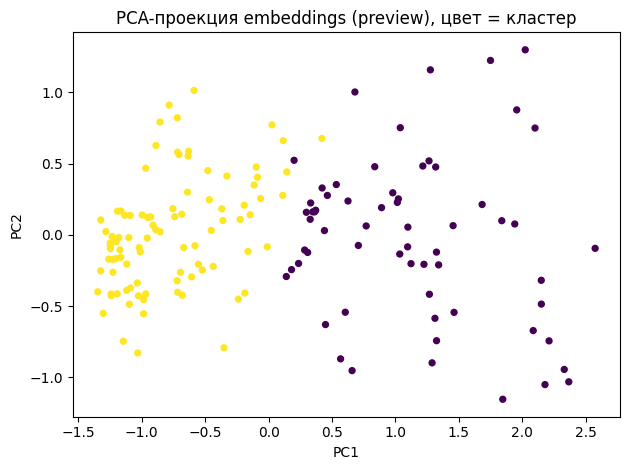

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA

RESULTS_DIR = Path("/content/drive/MyDrive/Colab Projects/EdNet-Analysis/results_run")

user_metrics     = pd.read_csv(RESULTS_DIR / "user_metrics.csv")
train_history    = pd.read_csv(RESULTS_DIR / "train_history.csv")
sil              = pd.read_csv(RESULTS_DIR / "silhouette_scores.csv")
cluster_profile  = pd.read_csv(RESULTS_DIR / "cluster_profile.csv")
user_clusters    = pd.read_csv(RESULTS_DIR / "user_clusters.csv")
controls         = pd.read_csv(RESULTS_DIR / "generation_controls_proxy.csv")
emb_preview      = pd.read_csv(RESULTS_DIR / "user_embeddings_preview.csv")

def save_show(fig_name: str):
    out = RESULTS_DIR / f"{fig_name}.png"
    plt.savefig(out, dpi=200, bbox_inches="tight")
    plt.show()

# График 1: распределение long_gap_rate
plt.figure()
plt.hist(user_metrics["long_gap_rate"], bins=50)
plt.title("График 1. Распределение long_gap_rate (прокси длительных пауз)")
plt.xlabel("long_gap_rate")
plt.ylabel("число пользователей")
plt.tight_layout()
save_show("fig01_long_gap_rate_hist")

# График 2: распределение активности n_events (лог-шкала)
plt.figure()
plt.hist(np.log1p(user_metrics["n_events"]), bins=60)
plt.title("График 2. Распределение log(1+n_events) по пользователям")
plt.xlabel("log(1+n_events)")
plt.ylabel("число пользователей")
plt.tight_layout()
save_show("fig02_log1p_n_events_hist")

# График 3: распределение темпа tempo_mean_bucket
plt.figure()
plt.hist(user_metrics["tempo_mean_bucket"], bins=50)
plt.title("График 3. Распределение tempo_mean_bucket")
plt.xlabel("tempo_mean_bucket")
plt.ylabel("число пользователей")
plt.tight_layout()
save_show("fig03_tempo_mean_bucket_hist")

# График 4: распределение long_gap_rate
plt.figure()
plt.hist(user_metrics["long_gap_rate"], bins=50)
plt.title("График 4. Распределение long_gap_rate")
plt.xlabel("long_gap_rate")
plt.ylabel("число пользователей")
plt.tight_layout()
save_show("fig04_long_gap_rate_hist_repeat")

# График 5: кривая обучения
plt.figure()
plt.plot(train_history["epoch"], train_history["train_loss"], marker="o", label="train_loss")
if "val_loss" in train_history.columns:
    plt.plot(train_history["epoch"], train_history["val_loss"], marker="o", label="val_loss")
plt.title("График 5. Динамика функции потерь при обучении GRU")
plt.xlabel("эпоха")
plt.ylabel("loss")
plt.legend()
plt.tight_layout()
save_show("fig05_training_curve_loss")

# График 6: silhouette / K
plt.figure()
plt.plot(sil["k"], sil["silhouette"], marker="o")
plt.title("График 6. Silhouette score в зависимости от числа кластеров K")
plt.xlabel("K")
plt.ylabel("silhouette")
plt.tight_layout()
save_show("fig06_silhouette_vs_k")

# Таблица 2: профиль кластеров
display(cluster_profile)

# График 7: размеры кластеров
plt.figure()
plt.bar(cluster_profile["cluster"].astype(str), cluster_profile["n_users"])
plt.title("График 7. Размеры кластеров в пространстве embeddings")
plt.xlabel("кластер")
plt.ylabel("число пользователей")
plt.tight_layout()
save_show("fig07_cluster_sizes")

# Графики 8–10: boxplot сравнение кластеров по метрикам
merged = user_metrics.merge(user_clusters, on="uid", how="inner")


for i, col in enumerate(["tempo_mean_bucket", "slow_share", "long_gap_rate"], start=8):
    plt.figure()
    d0 = merged.loc[merged["cluster"] == 0, col].values
    d1 = merged.loc[merged["cluster"] == 1, col].values
    plt.boxplot([d0, d1], labels=["cluster 0", "cluster 1"], showfliers=False)
    plt.title(f"График {i}. Сравнение кластеров по {col}")
    plt.ylabel(col)
    plt.tight_layout()
    save_show(f"fig{i:02d}_boxplot_{col}")

# Таблица 3: распределение управляющих параметров (controls)
pacing_counts = controls["target_pacing"].value_counts()
hint_counts = controls["hint_level"].value_counts()

print("Таблица 3а. Распределение target_pacing:\n", pacing_counts)
print("\nТаблица 3б. Распределение hint_level:\n", hint_counts)

# График 11а: распределение target_pacing
plt.figure()
plt.bar(pacing_counts.index.astype(str), pacing_counts.values)
plt.title("График 11а. Распределение target_pacing")
plt.xlabel("target_pacing")
plt.ylabel("число пользователей")
plt.tight_layout()
save_show("fig11a_target_pacing_distribution")

# График 11б: распределение hint_level
plt.figure()
plt.bar(hint_counts.index.astype(str), hint_counts.values)
plt.title("График 11б. Распределение hint_level")
plt.xlabel("hint_level")
plt.ylabel("число пользователей")
plt.tight_layout()
save_show("fig11b_hint_level_distribution")

# Дополнительно: PCA-проекция embedding
emb_cols = [c for c in emb_preview.columns if c.startswith("emb_")]
Z = emb_preview[emb_cols].values
uids = emb_preview["uid"].values

cl = user_clusters.set_index("uid").loc[uids]["cluster"].values

pca = PCA(n_components=2, random_state=42)
Z2 = pca.fit_transform(Z)

plt.figure()
plt.scatter(Z2[:, 0], Z2[:, 1], c=cl, s=18)
plt.title("PCA-проекция embeddings (preview), цвет = кластер")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
save_show("fig12_embeddings_pca2d_by_cluster")

In [19]:
!pip -q install scipy scikit-learn

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from pathlib import Path
from collections import defaultdict
from tqdm.auto import tqdm

from scipy.stats import mannwhitneyu
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA

RESULTS_DIR = Path("/content/drive/MyDrive/Colab Projects/EdNet-Analysis/results_run")
MODEL_PARQUET = RESULTS_DIR / "model_df.parquet"
assert MODEL_PARQUET.exists(), f"Not found: {MODEL_PARQUET}"

df0 = pl.read_parquet(MODEL_PARQUET).sort(["uid", "timestamp"])
print("Loaded:", MODEL_PARQUET)
print("Shape:", df0.shape)
print(df0.head(3))

# settings
SEED = 42
SEQ_LEN = 100          # lowered to increase coverage vs 200
STRIDE = 50            # sliding windows
BATCH = 64

SESSION_GAP_SEC = 1800 # 30 minutes = long gap definition
RUN_TAG = f"v2_seq{SEQ_LEN}_stride{STRIDE}"

def save_fig(name):
    out = RESULTS_DIR / f"{RUN_TAG}_{name}.png"
    plt.savefig(out, dpi=200, bbox_inches="tight")
    plt.show()
    print("Saved image:", out)

np.random.seed(SEED)
torch.manual_seed(SEED)

Loaded: /content/drive/MyDrive/Colab Projects/EdNet-Analysis/results_run/model_df.parquet
Shape: (215956, 8)
shape: (3, 8)
┌─────┬────────────┬───────────────┬──────┬─────┬───────────┬─────────┬───────┐
│ uid ┆ session_id ┆ timestamp     ┆ qid  ┆ ans ┆ elapsed_b ┆ delta_b ┆ split │
│ --- ┆ ---        ┆ ---           ┆ ---  ┆ --- ┆ ---       ┆ ---     ┆ ---   │
│ i32 ┆ i32        ┆ i64           ┆ i32  ┆ i16 ┆ i16       ┆ i16     ┆ str   │
╞═════╪════════════╪═══════════════╪══════╪═════╪═══════════╪═════════╪═══════╡
│ 476 ┆ 0          ┆ 1561522500603 ┆ 6355 ┆ 0   ┆ 1         ┆ 0       ┆ train │
│ 476 ┆ 0          ┆ 1561522515901 ┆ 3692 ┆ 2   ┆ 1         ┆ 1       ┆ train │
│ 476 ┆ 0          ┆ 1561522543830 ┆ 3817 ┆ 1   ┆ 2         ┆ 1       ┆ train │
└─────┴────────────┴───────────────┴──────┴─────┴───────────┴─────────┴───────┘


Eligible users (L>=SEQ_LEN+1): 274
Train users: 219 Val users: 27 Test users: 28

User metrics v2 (head):
   uid  n_events  n_sessions  tempo_mean_bucket  tempo_std_bucket  slow_share  pause_mean_bucket  pause_std_bucket  long_gap_rate
148689      6675         249           2.259326          0.707648    0.278052           0.817378          1.103050       0.037154
 20557      6104          95           1.718873          0.811557    0.165629           0.848132          0.872338       0.015400
245423      5435         313           2.448022          0.865023    0.442134           1.330819          1.226111       0.057406
123407      4461         152           2.176194          0.795941    0.293432           1.008742          1.001418       0.033849
185885      4001         167           2.065484          0.824142    0.232192           1.210197          1.080072       0.041490
 11416      3972         295           2.029960          0.709229    0.211229           1.544058          0.944345

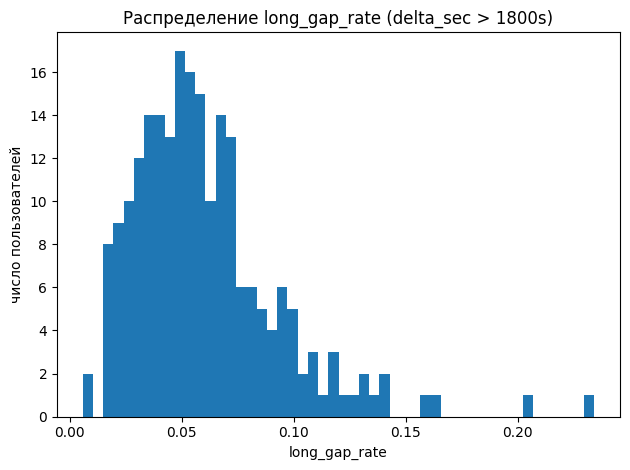

Saved image: /content/drive/MyDrive/Colab Projects/EdNet-Analysis/results_run/v2_seq100_stride50_fig01_long_gap_rate_hist_v2.png


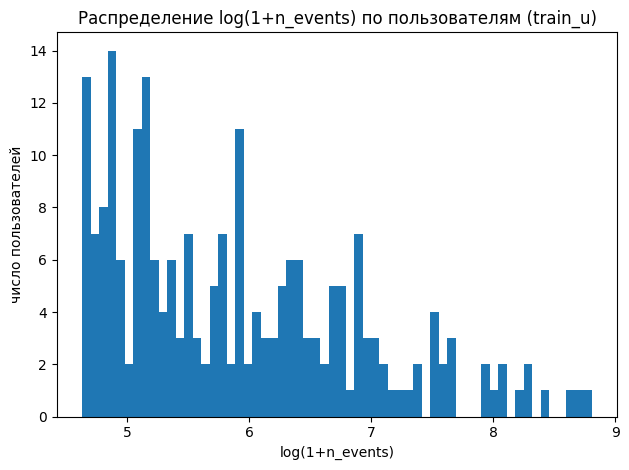

Saved image: /content/drive/MyDrive/Colab Projects/EdNet-Analysis/results_run/v2_seq100_stride50_fig02_log1p_n_events_hist_v2.png


In [20]:
#user-level split by eligibility (L >= SEQ_LEN+1)
lens = df0.group_by("uid").agg(pl.len().alias("L")).sort("L", descending=True)
eligible = lens.filter(pl.col("L") >= SEQ_LEN + 1)["uid"].to_list()
eligible = np.array(eligible, dtype=np.int32)

rng = np.random.default_rng(SEED)
rng.shuffle(eligible)

n = len(eligible)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)

train_uids = set(eligible[:n_train].tolist())
val_uids   = set(eligible[n_train:n_train+n_val].tolist())
test_uids  = set(eligible[n_train+n_val:].tolist())

def uid_to_split(uid: int):
    if uid in train_uids: return "train_u"
    if uid in val_uids:   return "val_u"
    return "test_u"

df_u = (
    df0
    .with_columns([
        pl.col("uid").map_elements(uid_to_split, return_dtype=pl.Utf8).alias("split_u"),
        ((pl.col("timestamp").diff().over("uid"))/1000.0).fill_null(0).alias("delta_sec"),  # seconds
    ])
    .with_columns([
        (pl.col("delta_sec") > SESSION_GAP_SEC).cast(pl.Int8).alias("long_gap"),
    ])
    .sort(["uid", "timestamp"])
)

print("Eligible users (L>=SEQ_LEN+1):", n)
print("Train users:", len(train_uids), "Val users:", len(val_uids), "Test users:", len(test_uids))

#user metrics v2 (with corrected long_gap)
train_part = df_u.filter(pl.col("split_u") == "train_u")

p80_elapsed = train_part.select(pl.col("elapsed_b").quantile(0.8)).item()

user_metrics_v2 = (
    train_part
    .group_by("uid")
    .agg([
        pl.len().alias("n_events"),
        pl.n_unique("session_id").alias("n_sessions"),
        pl.col("elapsed_b").mean().alias("tempo_mean_bucket"),
        pl.col("elapsed_b").std().fill_null(0).alias("tempo_std_bucket"),
        (pl.col("elapsed_b") >= p80_elapsed).mean().alias("slow_share"),
        pl.col("delta_b").mean().alias("pause_mean_bucket"),
        pl.col("delta_b").std().fill_null(0).alias("pause_std_bucket"),
        pl.col("long_gap").mean().alias("long_gap_rate"),
    ])
    .sort("n_events", descending=True)
)

user_metrics_pd = user_metrics_v2.to_pandas()
print("\nUser metrics v2 (head):")
print(user_metrics_pd.head(10).to_string(index=False))

# Figures: long_gap_rate + n_events
plt.figure()
plt.hist(user_metrics_pd["long_gap_rate"], bins=50)
plt.title("Распределение long_gap_rate (delta_sec > 1800s)")
plt.xlabel("long_gap_rate")
plt.ylabel("число пользователей")
plt.tight_layout()
save_fig("fig01_long_gap_rate_hist_v2")

plt.figure()
plt.hist(np.log1p(user_metrics_pd["n_events"]), bins=60)
plt.title("Распределение log(1+n_events) по пользователям (train_u)")
plt.xlabel("log(1+n_events)")
plt.ylabel("число пользователей")
plt.tight_layout()
save_fig("fig02_log1p_n_events_hist_v2")

In [21]:
# vocab built on train_u qids only
train_qids = train_part.select("qid").unique()["qid"].to_list()
qid_to_idx = {int(q): i+1 for i, q in enumerate(train_qids)}   # 0 = UNK/PAD
Q_VOCAB = len(qid_to_idx) + 1

ANS_VOCAB = int(df_u.select(pl.col("ans").max()).item()) + 2

# bucket vocabs: shift by +1 so that -1 becomes 0 (PAD/UNK)
el_max = int(df_u.select(pl.col("elapsed_b").max()).item())
dl_max = int(df_u.select(pl.col("delta_b").max()).item())
EL_VOCAB = el_max + 3   # +1 shift plus safe margin
DL_VOCAB = dl_max + 3

print("Vocab sizes:", {"Q_VOCAB": Q_VOCAB, "ANS_VOCAB": ANS_VOCAB, "EL_VOCAB": EL_VOCAB, "DL_VOCAB": DL_VOCAB})

def map_qid(qid: int) -> int:
    return qid_to_idx.get(int(qid), 0)

def map_bucket(x) -> int:
    # shift by +1; negatives -> 0
    v = int(x) if x is not None else -1
    v = v + 1
    return v if v >= 0 else 0

class KTWindowDatasetU(Dataset):
    def __init__(self, df: pl.DataFrame, split_u: str, seq_len: int, stride: int):
        self.seq_len = seq_len
        self.stride = stride
        d = df.filter(pl.col("split_u") == split_u).sort(["uid", "timestamp"])

        self.windows = []
        self.user_data = {}

        for uid, sub in d.group_by("uid", maintain_order=True):
            uid = int(uid[0])
            sub = sub.sort("timestamp")

            q = [map_qid(x) for x in sub["qid"].to_list()]
            a = [int(x) for x in sub["ans"].to_list()]
            e = [map_bucket(x) for x in sub["elapsed_b"].to_list()]
            g = [map_bucket(x) for x in sub["delta_b"].to_list()]

            if len(q) < seq_len + 1:
                continue

            self.user_data[uid] = (q, a, e, g)
            for start in range(0, len(q) - (seq_len + 1) + 1, stride):
                self.windows.append((uid, start))

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        uid, start = self.windows[idx]
        q, a, e, g = self.user_data[uid]
        sl = slice(start, start + self.seq_len)

        qx = torch.tensor(q[sl], dtype=torch.long)
        ax = torch.tensor(a[sl], dtype=torch.long)
        ex = torch.tensor(e[sl], dtype=torch.long)
        gx = torch.tensor(g[sl], dtype=torch.long)
        y  = torch.tensor(q[start+1:start+self.seq_len+1], dtype=torch.long)

        return (qx, ax, ex, gx), y, uid

train_ds = KTWindowDatasetU(df_u, "train_u", SEQ_LEN, STRIDE)
val_ds   = KTWindowDatasetU(df_u, "val_u",   SEQ_LEN, STRIDE)
test_ds  = KTWindowDatasetU(df_u, "test_u",  SEQ_LEN, STRIDE)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=0)

print("Windows:", {"train": len(train_ds), "val": len(val_ds), "test": len(test_ds)})

x, y, uid = next(iter(train_loader))
print("Batch check:", x[0].shape, y.shape)

Vocab sizes: {'Q_VOCAB': 11610, 'ANS_VOCAB': 6, 'EL_VOCAB': 9, 'DL_VOCAB': 8}
Windows: {'train': 2586, 'val': 355, 'test': 399}
Batch check: torch.Size([64, 100]) torch.Size([64, 100])


Device: cpu
Epoch 01: train_loss=8.8754 val_loss=8.4462 lr=1.00e-03
Epoch 02: train_loss=8.3537 val_loss=8.1931 lr=1.00e-03
Epoch 03: train_loss=8.1204 val_loss=8.0184 lr=1.00e-03
Epoch 04: train_loss=7.9157 val_loss=7.8444 lr=1.00e-03
Epoch 05: train_loss=7.7180 val_loss=7.7311 lr=1.00e-03
Epoch 06: train_loss=7.5496 val_loss=7.6258 lr=1.00e-03
Epoch 07: train_loss=7.3869 val_loss=7.5273 lr=1.00e-03
Epoch 08: train_loss=7.2258 val_loss=7.4263 lr=1.00e-03
Epoch 09: train_loss=7.0630 val_loss=7.3343 lr=1.00e-03
Epoch 10: train_loss=6.8992 val_loss=7.2236 lr=1.00e-03
Epoch 11: train_loss=6.7370 val_loss=7.1243 lr=1.00e-03
Epoch 12: train_loss=6.5702 val_loss=7.0208 lr=1.00e-03
Epoch 13: train_loss=6.4112 val_loss=6.9200 lr=1.00e-03
Epoch 14: train_loss=6.2512 val_loss=6.8217 lr=1.00e-03
Epoch 15: train_loss=6.0985 val_loss=6.7450 lr=1.00e-03

Training history:
 epoch  train_loss  val_loss    lr
     1    8.875442  8.446235 0.001
     2    8.353705  8.193107 0.001
     3    8.120371  8.01

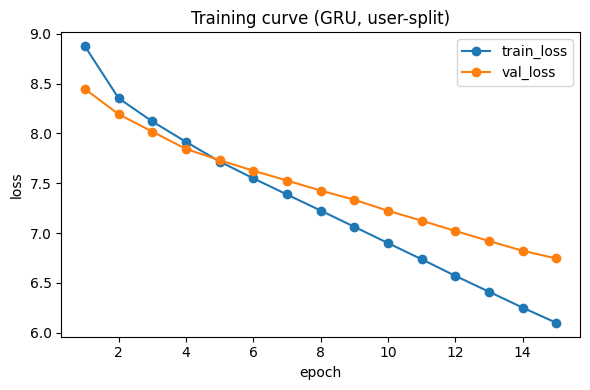

Saved image: /content/drive/MyDrive/Colab Projects/EdNet-Analysis/results_run/v2_seq100_stride50_fig03_training_curve.png
Loaded best model: /content/drive/MyDrive/Colab Projects/EdNet-Analysis/results_run/v2_seq100_stride50_gru_best.pt best_val_loss= 6.744956262346724


In [22]:
class GRUKT2(nn.Module):
    def __init__(self, q_vocab, ans_vocab, el_vocab, dl_vocab, d_model=96, hidden=192, num_layers=2, dropout=0.2):
        super().__init__()
        self.q_emb  = nn.Embedding(q_vocab, d_model, padding_idx=0)
        self.a_emb  = nn.Embedding(ans_vocab, d_model)
        self.el_emb = nn.Embedding(el_vocab, d_model)
        self.dl_emb = nn.Embedding(dl_vocab, d_model)

        self.drop = nn.Dropout(dropout)
        self.gru = nn.GRU(
            input_size=d_model*4,
            hidden_size=hidden,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True
        )
        self.out = nn.Linear(hidden, q_vocab)

    def forward(self, qx, ax, ex, gx):
        x = torch.cat([self.q_emb(qx), self.a_emb(ax), self.el_emb(ex), self.dl_emb(gx)], dim=-1)
        x = self.drop(x)
        h_seq, h_last = self.gru(x)
        logits = self.out(h_seq)
        return logits, h_seq, h_last  # h_last: [layers,B,H]

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)
if device == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

model = GRUKT2(Q_VOCAB, ANS_VOCAB, EL_VOCAB, DL_VOCAB).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss(ignore_index=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=2)

def run_epoch(loader, train=True):
    model.train(train)
    total_loss, n = 0.0, 0
    for (qx, ax, ex, gx), y, _ in loader:
        qx, ax, ex, gx, y = qx.to(device), ax.to(device), ex.to(device), gx.to(device), y.to(device)
        logits, _, _ = model(qx, ax, ex, gx)
        loss = criterion(logits.reshape(-1, logits.size(-1)), y.reshape(-1))

        if train:
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        total_loss += float(loss.item()) * qx.size(0)
        n += qx.size(0)
    return total_loss / max(n, 1)

EPOCHS = 15
PATIENCE = 4
best_val = 1e18
bad = 0
history = []

BEST_PT = RESULTS_DIR / f"{RUN_TAG}_gru_best.pt"

for ep in range(1, EPOCHS+1):
    tr = run_epoch(train_loader, train=True)
    va = run_epoch(val_loader, train=False) if len(val_ds) > 0 else float("nan")
    scheduler.step(va if np.isfinite(va) else tr)

    lr_now = opt.param_groups[0]["lr"]
    history.append({"epoch": ep, "train_loss": tr, "val_loss": va, "lr": lr_now})
    print(f"Epoch {ep:02d}: train_loss={tr:.4f} val_loss={va:.4f} lr={lr_now:.2e}")

    if np.isfinite(va) and va < best_val:
        best_val = va
        bad = 0
        torch.save(model.state_dict(), BEST_PT)
    else:
        bad += 1
        if bad >= PATIENCE:
            break

hist_pd = pd.DataFrame(history)
print("\nTraining history:")
print(hist_pd.to_string(index=False))

# plot training curve
plt.figure(figsize=(6,4))
plt.plot(hist_pd["epoch"], hist_pd["train_loss"], marker="o", label="train_loss")
if hist_pd["val_loss"].notna().any():
    plt.plot(hist_pd["epoch"], hist_pd["val_loss"], marker="o", label="val_loss")
plt.title("Training curve (GRU, user-split)")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.tight_layout()
save_fig("fig03_training_curve")

# load best
if BEST_PT.exists():
    model.load_state_dict(torch.load(BEST_PT, map_location=device))
    model.eval()
    print("Loaded best model:", BEST_PT, "best_val_loss=", best_val)

In [23]:
@torch.no_grad()
def eval_gru(loader, topk=5, use_time=True):
    total = 0
    hit = 0
    rr_sum = 0.0

    for (qx, ax, ex, gx), y, _ in loader:
        qx, ax, ex, gx, y = qx.to(device), ax.to(device), ex.to(device), gx.to(device), y.to(device)
        if not use_time:
            ex = torch.zeros_like(ex)
            gx = torch.zeros_like(gx)

        logits, _, _ = model(qx, ax, ex, gx)
        top_idx = torch.topk(logits, k=topk, dim=-1).indices

        y_flat = y.reshape(-1)
        top_flat = top_idx.reshape(-1, topk)

        mask = y_flat != 0
        y_m = y_flat[mask]
        top_m = top_flat[mask]

        eq = top_m.eq(y_m.unsqueeze(1))
        any_hit = eq.any(dim=1)

        hit += any_hit.sum().item()
        total += y_m.numel()

        ranks = torch.argmax(eq.int(), dim=1) + 1
        rr = torch.where(any_hit, 1.0 / ranks.float(), torch.zeros_like(ranks, dtype=torch.float))
        rr_sum += rr.sum().item()

    return hit / max(total,1), rr_sum / max(total,1), total

rows = []
for K in [5,10]:
    for split_name, loader in [("VAL", val_loader), ("TEST", test_loader)]:
        r1, m1, n = eval_gru(loader, topk=K, use_time=True)
        r2, m2, _ = eval_gru(loader, topk=K, use_time=False)
        rows.append({"split": split_name, "K": K, "use_time": True,  "recall@K": r1, "MRR@K": m1, "N": n})
        rows.append({"split": split_name, "K": K, "use_time": False, "recall@K": r2, "MRR@K": m2, "N": n})

metrics_pd = pd.DataFrame(rows)
print(metrics_pd.to_string(index=False))

split  K  use_time  recall@K    MRR@K     N
  VAL  5      True  0.211151 0.163509 35406
  VAL  5     False  0.140993 0.101330 35406
 TEST  5      True  0.167960 0.130188 39694
 TEST  5     False  0.111050 0.080285 39694
  VAL 10      True  0.238067 0.167079 35406
  VAL 10     False  0.167655 0.104872 35406
 TEST 10      True  0.191742 0.133366 39694
 TEST 10     False  0.133194 0.083253 39694


In [24]:
# Build pairs from train_u
train_sorted = df_u.filter(pl.col("split_u")=="train_u").sort(["uid","timestamp"]).select(["uid","timestamp","qid"])
pairs = (
    train_sorted
    .with_columns([
        pl.col("qid").map_elements(lambda x: map_qid(x), return_dtype=pl.Int64).alias("q_idx"),
        pl.col("qid").shift(-1).over("uid").map_elements(lambda x: map_qid(x) if x is not None else 0, return_dtype=pl.Int64).alias("next_idx")
    ])
    .filter(pl.col("next_idx") != 0)
    .select(["q_idx","next_idx"])
)
pairs_pd = pairs.to_pandas()

# Frequency baseline
freq_counts = pairs_pd["next_idx"].value_counts()
freq_top = freq_counts.index.to_numpy()

# Markov baseline
markov = {}
vc = pairs_pd.groupby("q_idx")["next_idx"].value_counts()
for (q, nxt), c in vc.items():
    markov.setdefault(int(q), []).append((int(nxt), int(c)))
for q in markov:
    markov[q] = [n for n,_ in sorted(markov[q], key=lambda t: -t[1])]

def eval_baseline(loader, topk=5, mode="freq"):
    total = 0
    hit = 0
    rr_sum = 0.0

    for (qx, ax, ex, gx), y, _ in loader:
        qx = qx.numpy()
        y = y.numpy()
        B, T = y.shape

        for i in range(B):
            for t in range(T):
                yt = int(y[i,t])
                if yt == 0:
                    continue
                cur = int(qx[i,t])

                if mode == "freq":
                    pred = freq_top[:topk]
                else:
                    plist = markov.get(cur)
                    pred = np.array(plist[:topk], dtype=int) if plist else freq_top[:topk]

                total += 1
                if yt in pred:
                    hit += 1
                    rank = int(np.where(pred == yt)[0][0]) + 1
                    rr_sum += 1.0 / rank

    return hit / max(total,1), rr_sum / max(total,1), total

rows = []
for K in [5,10]:
    for split_name, loader in [("VAL", val_loader), ("TEST", test_loader)]:
        r_f, m_f, n = eval_baseline(loader, topk=K, mode="freq")
        r_m, m_m, _ = eval_baseline(loader, topk=K, mode="markov")
        rows.append({"split": split_name, "K": K, "baseline": "freq",   "recall@K": r_f, "MRR@K": m_f, "N": n})
        rows.append({"split": split_name, "K": K, "baseline": "markov", "recall@K": r_m, "MRR@K": m_m, "N": n})

baseline_pd = pd.DataFrame(rows)
print(baseline_pd.to_string(index=False))

split  K baseline  recall@K    MRR@K     N
  VAL  5     freq  0.004011 0.001896 35406
  VAL  5   markov  0.300909 0.231591 35406
 TEST  5     freq  0.005013 0.002459 39694
 TEST  5   markov  0.249080 0.192780 39694
  VAL 10     freq  0.008191 0.002438 35406
  VAL 10   markov  0.309044 0.232709 35406
 TEST 10     freq  0.008616 0.002926 39694
 TEST 10   markov  0.256336 0.193801 39694


Embedding pass:   0%|          | 0/41 [00:00<?, ?it/s]

Embedding pass:   0%|          | 0/6 [00:00<?, ?it/s]

Embedding pass:   0%|          | 0/7 [00:00<?, ?it/s]

Embeddings extracted: (274, 192)

Silhouette by K:
 k  silhouette
 2    0.219257
 3    0.205194
 4    0.210757
 5    0.156185
 6    0.121611
 7    0.106594
 8    0.109407
Best K: 2 best silhouette: 0.21925674378871918


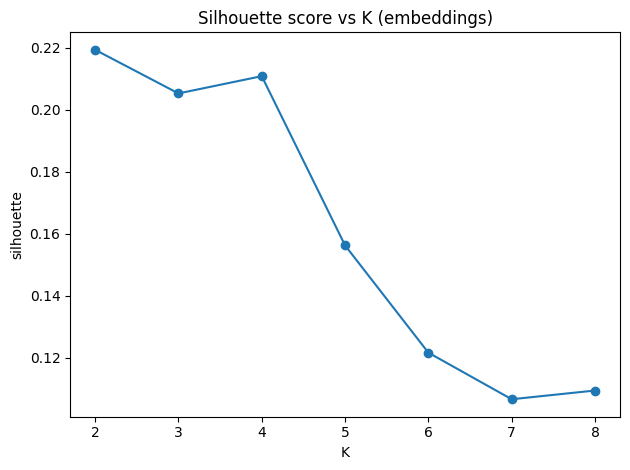

Saved image: /content/drive/MyDrive/Colab Projects/EdNet-Analysis/results_run/v2_seq100_stride50_fig04_silhouette_vs_k.png

Cluster profile:
 cluster  n_users  median_events  tempo_mean  tempo_std  slow_share_mean  pause_mean  pause_std  long_gap_rate_mean
       0      148          210.0    1.941249   0.770575         0.206092    1.422772   0.972892            0.067411
       1      126          461.5    2.120338   0.767710         0.273134    1.208985   1.080146            0.052111


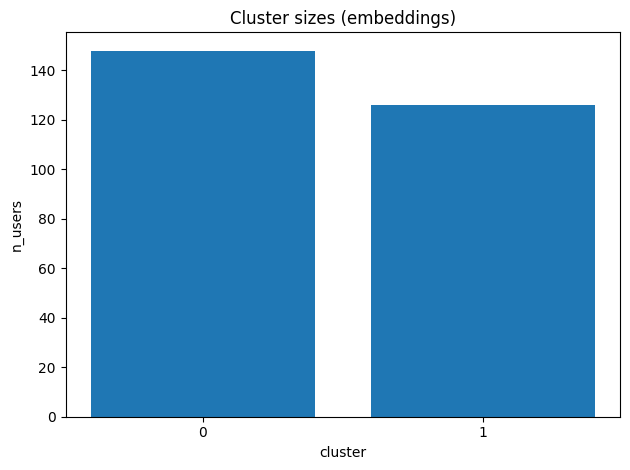

Saved image: /content/drive/MyDrive/Colab Projects/EdNet-Analysis/results_run/v2_seq100_stride50_fig05_cluster_sizes.png

Cluster stability table:
             method  random_state  silhouette      DBI        CH
             KMeans           0.0    0.219488 1.693919 80.277077
             KMeans          42.0    0.219257 1.690866 80.290039
             KMeans         123.0    0.219488 1.693919 80.277077
             KMeans         999.0    0.219488 1.693919 80.277077
                GMM          42.0    0.219537 1.696299 80.250793
Agglomerative(ward)           NaN    0.186337 1.670083 66.919807


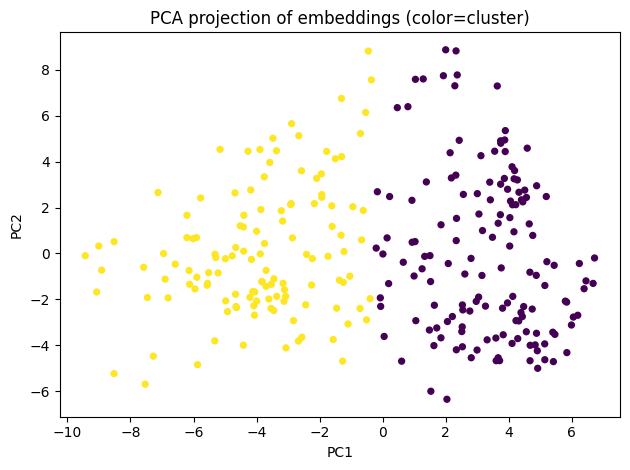

Saved image: /content/drive/MyDrive/Colab Projects/EdNet-Analysis/results_run/v2_seq100_stride50_fig06_pca_embeddings_by_cluster.png


In [25]:
# Extract embeddings as mean of last-layer hidden state (h_last from GRU layers)
model.eval()
user_sum = defaultdict(lambda: torch.zeros(192))  # hidden size in GRUKT2 = 192
user_cnt = defaultdict(int)

@torch.no_grad()
def extract_from_loader(loader):
    for (qx, ax, ex, gx), _, uids in tqdm(loader, desc="Embedding pass", leave=False):
        qx, ax, ex, gx = qx.to(device), ax.to(device), ex.to(device), gx.to(device)
        _, _, h_last = model(qx, ax, ex, gx)            # [layers,B,H]
        emb = h_last[-1].cpu()                          # last layer: [B,H]
        for i, uid in enumerate(uids):
            uid = int(uid)
            user_sum[uid] += emb[i]
            user_cnt[uid] += 1

extract_from_loader(train_loader)
if len(val_ds) > 0:  extract_from_loader(val_loader)
if len(test_ds) > 0: extract_from_loader(test_loader)

user_ids = sorted(user_sum.keys())
emb_mat = np.stack([(user_sum[uid] / user_cnt[uid]).numpy() for uid in user_ids], axis=0)

print("Embeddings extracted:", emb_mat.shape)

# silhouette vs K
Ks = list(range(2, 9))
sil_rows = []
best_k, best_sil = None, -1

for k in Ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(emb_mat)
    sil = silhouette_score(emb_mat, labels)
    sil_rows.append({"k": k, "silhouette": float(sil)})
    if sil > best_sil:
        best_sil, best_k = float(sil), k

sil_pd = pd.DataFrame(sil_rows)
print("\nSilhouette by K:")
print(sil_pd.to_string(index=False))
print("Best K:", best_k, "best silhouette:", best_sil)

plt.figure()
plt.plot(sil_pd["k"], sil_pd["silhouette"], marker="o")
plt.title("Silhouette score vs K (embeddings)")
plt.xlabel("K")
plt.ylabel("silhouette")
plt.tight_layout()
save_fig("fig04_silhouette_vs_k")

# choose best K clustering
kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
labels = kmeans.fit_predict(emb_mat)

# cluster profile using user_metrics_pd (only train_u users)
user_clusters_pd = pd.DataFrame({"uid": user_ids, "cluster": labels})
merged = user_clusters_pd.merge(user_metrics_pd, on="uid", how="left")

cluster_profile_pd = (
    merged.groupby("cluster")
          .agg(
              n_users=("uid","count"),
              median_events=("n_events","median"),
              tempo_mean=("tempo_mean_bucket","mean"),
              tempo_std=("tempo_std_bucket","mean"),
              slow_share_mean=("slow_share","mean"),
              pause_mean=("pause_mean_bucket","mean"),
              pause_std=("pause_std_bucket","mean"),
              long_gap_rate_mean=("long_gap_rate","mean"),
          )
          .reset_index()
          .sort_values("n_users", ascending=False)
)

print("\nCluster profile:")
print(cluster_profile_pd.to_string(index=False))

# cluster size figure
plt.figure()
plt.bar(cluster_profile_pd["cluster"].astype(str), cluster_profile_pd["n_users"])
plt.title("Cluster sizes (embeddings)")
plt.xlabel("cluster")
plt.ylabel("n_users")
plt.tight_layout()
save_fig("fig05_cluster_sizes")

# stability metrics for K=best_k
Z = emb_mat
stab_rows = []
for rs in [0, 42, 123, 999]:
    km = KMeans(n_clusters=best_k, n_init=10, random_state=rs)
    lab = km.fit_predict(Z)
    stab_rows.append({
        "method":"KMeans", "random_state":rs,
        "silhouette": float(silhouette_score(Z, lab)),
        "DBI": float(davies_bouldin_score(Z, lab)),
        "CH": float(calinski_harabasz_score(Z, lab)),
    })

gmm = GaussianMixture(n_components=best_k, covariance_type="full", random_state=42)
lab = gmm.fit_predict(Z)
stab_rows.append({
    "method":"GMM", "random_state":42,
    "silhouette": float(silhouette_score(Z, lab)),
    "DBI": float(davies_bouldin_score(Z, lab)),
    "CH": float(calinski_harabasz_score(Z, lab)),
})

agg = AgglomerativeClustering(n_clusters=best_k, linkage="ward")
lab = agg.fit_predict(Z)
stab_rows.append({
    "method":"Agglomerative(ward)", "random_state":None,
    "silhouette": float(silhouette_score(Z, lab)),
    "DBI": float(davies_bouldin_score(Z, lab)),
    "CH": float(calinski_harabasz_score(Z, lab)),
})
stab_pd = pd.DataFrame(stab_rows)
print("\nCluster stability table:")
print(stab_pd.to_string(index=False))

# PCA plot (2D)
pca = PCA(n_components=2, random_state=42)
Z2 = pca.fit_transform(emb_mat)

plt.figure()
plt.scatter(Z2[:,0], Z2[:,1], c=labels, s=18)
plt.title("PCA projection of embeddings (color=cluster)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
save_fig("fig06_pca_embeddings_by_cluster")

In [26]:
def cliffs_delta(x, y):
    x = np.asarray(x); y = np.asarray(y)
    return (np.sum(x[:,None] > y[None,:]) - np.sum(x[:,None] < y[None,:])) / (len(x)*len(y))

diff_rows = []
for col in ["slow_share", "long_gap_rate", "tempo_mean_bucket", "n_events"]:
    x = merged[merged["cluster"]==0][col].dropna().values
    y = merged[merged["cluster"]==1][col].dropna().values
    if len(x)==0 or len(y)==0:
        continue
    stat, p = mannwhitneyu(x, y, alternative="two-sided")
    d = cliffs_delta(x, y)
    diff_rows.append({
        "metric": col,
        "n0": len(x), "n1": len(y),
        "median0": float(np.median(x)),
        "median1": float(np.median(y)),
        "p_value": float(p),
        "cliffs_delta": float(d),
    })

diff_pd = pd.DataFrame(diff_rows)
diff_pd["p_value"] = diff_pd["p_value"].apply(lambda v: f"{v:.3e}")
diff_pd["cliffs_delta"] = diff_pd["cliffs_delta"].round(6)

print(diff_pd.to_string(index=False))

           metric  n0  n1    median0    median1   p_value  cliffs_delta
       slow_share 119 100   0.180354   0.242773 1.030e-03     -0.257731
    long_gap_rate 119 100   0.059829   0.044247 4.308e-05      0.321176
tempo_mean_bucket 119 100   1.930931   2.087742 1.179e-05     -0.344034
         n_events 119 100 210.000000 461.500000 1.106e-05     -0.345126


In [27]:
# robust quantiles for difficulty_shift
lr = user_metrics_pd["long_gap_rate"].values
nz = lr[lr > 0]

if len(nz) >= 20:
    q1 = float(np.quantile(nz, 0.33))
    q2 = float(np.quantile(nz, 0.66))
else:
    q1 = float(np.quantile(lr, 0.33))
    q2 = float(np.quantile(lr, 0.66))

# fallback if degenerate
if not np.isfinite(q1) or not np.isfinite(q2) or q1 == q2:
    q1 = float(np.mean(lr))
    q2 = float(np.mean(lr) + np.std(lr))

print("difficulty_shift thresholds:", {"q1": q1, "q2": q2, "nonzero_count": int(len(nz))})

# pacing/hints thresholds
q40_tempo = float(np.quantile(user_metrics_pd["tempo_mean_bucket"].values, 0.4))
q40_slow  = float(np.quantile(user_metrics_pd["slow_share"].values, 0.4))
q70_slow  = float(np.quantile(user_metrics_pd["slow_share"].values, 0.7))
q70_tstd  = float(np.quantile(user_metrics_pd["tempo_std_bucket"].values, 0.7))

def make_controls_row(r):
    tempo = float(r["tempo_mean_bucket"])
    slow  = float(r["slow_share"])
    tstd  = float(r["tempo_std_bucket"])
    lgr   = float(r["long_gap_rate"])

    target_pacing = "fast" if (tempo <= q40_tempo and slow <= q40_slow) else "calm"
    hint_level = 2 if (slow >= q70_slow or tstd >= q70_tstd) else 1

    # 3-level difficulty_shift: low long-gap => +1, high long-gap => -1
    if lgr <= q1:
        diff = +1
    elif lgr >= q2:
        diff = -1
    else:
        diff = 0

    return target_pacing, hint_level, diff

controls_rows = []
for _, r in user_metrics_pd.iterrows():
    tp, hl, ds = make_controls_row(r)
    controls_rows.append((int(r["uid"]), tp, hl, ds))

controls_v2 = pd.DataFrame(controls_rows, columns=["uid","target_pacing","hint_level","difficulty_shift"])

print("\nControls v2 counts:")
print("target_pacing:")
print(controls_v2["target_pacing"].value_counts().to_string())
print("\nhint_level:")
print(controls_v2["hint_level"].value_counts().to_string())
print("\ndifficulty_shift:")
print(controls_v2["difficulty_shift"].value_counts().to_string())

print("\nControls v2 head:")
print(controls_v2.head(10).to_string(index=False))

difficulty_shift thresholds: {'q1': 0.04337067015519163, 'q2': 0.0658509060325713, 'nonzero_count': 219}

Controls v2 counts:
target_pacing:
target_pacing
calm    147
fast     72

hint_level:
hint_level
1    125
2     94

difficulty_shift:
difficulty_shift
-1    75
 1    72
 0    72

Controls v2 head:
   uid target_pacing  hint_level  difficulty_shift
148689          calm           1                 1
 20557          fast           1                 1
245423          calm           2                 0
123407          calm           1                 1
185885          calm           1                 1
 11416          calm           1                -1
758818          calm           2                 1
 80940          fast           1                 1
201862          calm           2                 0
 82991          calm           2                 1


In [28]:
import pandas as pd
import numpy as np

def generation_policy_row(pacing: str, hint: int, diff: int):
    if pacing == "fast":
        pacing_rule = "Сократить объём объяснения; повысить плотность примеров; ускорить темп подачи."
        pacing_goal = "Снизить риск потери внимания при высоком темпе взаимодействия."
    else:
        pacing_rule = "Увеличить развёрнутость объяснения; добавить больше промежуточных шагов; поддерживать спокойный темп."
        pacing_goal = "Поддержать вдумчивое усвоение и снизить когнитивную перегрузку."

    # hint level
    if int(hint) >= 2:
        hint_rule = "Включить пошаговые подсказки и контрольные вопросы; допускать разъяснение типичных ошибок."
        hint_goal = "Повысить поддерживающую обратную связь и снизить фрустрацию."
    else:
        hint_rule = "Минимальный уровень подсказок; акцент на самостоятельное решение и проверку."
        hint_goal = "Сохранить автономность и не снижать сложность без необходимости."

    # difficulty shift
    if int(diff) == -1:
        diff_rule = "Сместить сложность вниз (упростить формулировки/уменьшить число шагов), добавить опорные примеры."
        diff_goal = "Снизить риск прерывания сессии при признаках нестабильности."
    elif int(diff) == 1:
        diff_rule = "Сместить сложность вверх (углубить требуемое рассуждение/добавить усложняющие элементы)."
        diff_goal = "Усилить обучающий эффект при устойчивом взаимодействии."
    else:
        diff_rule = "Сохранять базовый уровень сложности; адаптировать только стиль подачи."
        diff_goal = "Избежать нецелевого изменения сложности."

    mode_text = " ".join([pacing_rule, hint_rule, diff_rule])
    goal_text = " ".join([pacing_goal, hint_goal, diff_goal])

    return mode_text, goal_text

comb = (
    controls_v2[["target_pacing", "hint_level", "difficulty_shift"]]
    .value_counts()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

topN = min(3, len(comb))
top_comb = comb.head(topN).copy()

rows = []
for _, r in top_comb.iterrows():
    pacing = r["target_pacing"]
    hint = int(r["hint_level"])
    diff = int(r["difficulty_shift"])
    mode, goal = generation_policy_row(pacing, hint, diff)

    rows.append({
        "controls (pacing, hint, diff)": f"{pacing}, {hint}, {diff}",
        "Режим генерации/адаптации (без промта)": mode,
        "Ожидаемый педагогический эффект": goal,
        "Частота (пользователей)": int(r["count"])
    })

table9 = pd.DataFrame(rows)

print("\nExamples of generation modes by controls")
print(table9.to_string(index=False))


Examples of generation modes by controls]
controls (pacing, hint, diff)                                                                                                                                                                                                                                                             Режим генерации/адаптации (без промта)                                                                                                                                                           Ожидаемый педагогический эффект  Частота (пользователей)
                  calm, 2, -1 Увеличить развёрнутость объяснения; добавить больше промежуточных шагов; поддерживать спокойный темп. Включить пошаговые подсказки и контрольные вопросы; допускать разъяснение типичных ошибок. Сместить сложность вниз (упростить формулировки/уменьшить число шагов), добавить опорные примеры. Поддержать вдумчивое усвоение и снизить когнитивную перегрузку. Повысить поддерживающую обратную связь и